# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('F:\\UPGRAD\\5. Deep Learning\\Module 6 - Gesture recognition assignment\\Project_data\\Project_data\\train.csv').readlines())
val_doc = np.random.permutation(open('F:\\UPGRAD\\5. Deep Learning\\Module 6 - Gesture recognition assignment\\Project_data\\Project_data\\val.csv').readlines())
batch_size = 64 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
img_idx=0

In [5]:
x = 20 #umber of images selected in img_idx
y = 120 #size of image 
z = 120 #size of image 

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # Range is selected as (5,x+5) so that 20 images from the center of 30 images are selected (5th image to 24th image)
    img_idx = [x for x in range(5,x+5)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    img_new = resize(image,(y,z))
                    
                    img_new = img_new/255 # normalising 
                    
                    batch_data[folder,idx,:,:,0] = (img_new[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (img_new[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (img_new[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            # new batch size is the rest of the folders present after dividing the batch
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        img_new = resize(image,(y,z))
                    
                        img_new = img_new/255 # normalising 
                    
                        batch_data[folder,idx,:,:,0] = (img_new[:,:,0])#normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (img_new[:,:,1])#normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (img_new[:,:,2])#normalise and feed in the image
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'F:\\UPGRAD\\5. Deep Learning\\Module 6 - Gesture recognition assignment\\Project_data\\Project_data\\train'
val_path = 'F:\\UPGRAD\\5. Deep Learning\\Module 6 - Gesture recognition assignment\\Project_data\\Project_data\\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


# Model - Resnet 50 with 3D CNN

In [8]:
from keras import layers 
from keras.layers import Input,Add,Dense,Activation,ZeroPadding3D,BatchNormalization,Flatten,Conv3D,AveragePooling3D,MaxPooling3D
from keras.models import Model, load_model
from keras.preprocessing import image 
from keras.utils import layer_utils
from keras.utils.data_utils import get_file 
from keras.applications.imagenet_utils import preprocess_input 
#import pydot 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

### Identity Block 

In [9]:
def identity_block(X,f,filters):
    # Filters are given to the below values  
    F1,F2,F3 = filters
    
    X_shortcut = X #For saving the initial value of x
    
    #First layer 
    X = Conv3D(filters = F1, kernel_size =(1,1,1), strides=(1,1,1), padding='valid')(X)
    X = BatchNormalization(axis=4)(X)
    X = Activation('relu')(X)
     
    #Second layer 
    X = Conv3D(filters = F1, kernel_size =(f,f,f), strides=(1,1,1), padding='same')(X)
    X = BatchNormalization(axis=4)(X)
    X = Activation('relu')(X)
         
    #Third layer 
    X = Conv3D(filters = F1, kernel_size =(1,1,1), strides=(1,1,1), padding='valid')(X)
    X = BatchNormalization(axis=4)(X)
    X = Activation('relu')(X)
    
    # Final step : Adding X and 'initial value of X' and passing it through RELU
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

### Convolutional Block

In [10]:
def convolutional_block(X,f,filters,s=2):
    
    # Filters are given to the below values  
    F1,F2,F3 = filters
    
    X_shortcut = X #For saving the initial value of x
    
    #First layer 
    X = Conv3D(filters = F1, kernel_size =(1,1,1), strides=(s,s,s))(X)
    X = BatchNormalization(axis=4)(X)
    X = Activation('relu')(X)
     
    #Second layer 
    X = Conv3D(filters = F1, kernel_size =(f,f,f), strides=(1,1,1), padding='same')(X)
    X = BatchNormalization(axis=4)(X)
    X = Activation('relu')(X)
         
    #Third layer 
    X = Conv3D(filters = F1, kernel_size =(1,1,1), strides=(1,1,1), padding='valid')(X)
    X = BatchNormalization(axis=4)(X)
    X = Activation('relu')(X)
    
    #Here X_shortcut should be made the similar size of output X
    X_shortcut = Conv3D(filters = F1, kernel_size =(1,1,1), strides=(s,s,s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis=4)(X_shortcut)
    
    # Final step : Adding X and 'initial value of X' and passing it through RELU
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

## ResNet50 using the above 2 blocks 

In [11]:
def ResNet50(input_shape=(20, 120, 120, 3), classes =5):
    """
    Implementation of ResNet50 architecture :
    
    Stage_1: Conv3D -> BATCHNORM -> RELU -> MAXPOOL -> 
    Stage_2: -> CONVBLOCK -> IDBLOCK*2 ->
    Stage_3: -> CONVBLOCK -> IDBLOCK*3 -> 
    Stage_4: -> CONVBLOCK -> IDBLOCK*5 ->
    Stage_5: -> CONVBLOCK -> IDBLOCK*2 ->
    Stage_6: -> AVGPOOL -> TOP_LAYER
    """
    #Defining the input 
    X_input = Input(input_shape)
    
    #Zero padding 
    X = ZeroPadding3D((3,3,3))(X_input)# (3,3) padding of 0s
    
    #Stage 1 
    X = Conv3D(64,(7,7,7), strides =(2,2,2))(X)
    X = BatchNormalization(axis=4)(X)
    X = Activation('relu')(X)
    X = MaxPooling3D((3,3,3), strides=(2,2,2))(X)
    
    #Stage 2 
    X = convolutional_block(X, f=3,filters = [64,64,256], s=1)#Function similar to indentity block
    X = identity_block(X,3,[64,64,256])
    X = identity_block(X,3,[64,64,256])
    
    #Stage 3 
    X = convolutional_block(X, f=3,filters = [128,128,512], s=2)
    X = identity_block(X,3,[128,128,512])
    X = identity_block(X,3,[128,128,512])
    X = identity_block(X,3,[128,128,512])
    
    #Stage 4
    X = convolutional_block(X, f=3,filters = [256,256,1024], s=2)
    X = identity_block(X,3,[256,256,1024])
    X = identity_block(X,3,[256,256,1024])
    X = identity_block(X,3,[256,256,1024])
    X = identity_block(X,3,[256,256,1024])
    X = identity_block(X,3,[256,256,1024])
    
    #Stage 5 
    X = convolutional_block(X, f=3,filters = [512,512,2048], s=2)
    X = identity_block(X,3,[512,512,2048])
    X = identity_block(X,3,[512,512,2048])
    X = identity_block(X,3,[512,512,2048])
    
    #Stage 6
   # X = AveragePooling3D((2,2,2), strides=None, padding='same',name='avg_pool')(X)
    
    #Output Layer 
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax', name='fc'+str(classes),kernel_initializer = glorot_uniform(seed=0))(X)
    
    #Create model 
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    return model

In [12]:
model = ResNet50(input_shape = (20, 120, 120, 3), classes=5)

In [13]:
from keras import optimizers
optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 120, 120 0                                            
__________________________________________________________________________________________________
zero_padding3d (ZeroPadding3D)  (None, 26, 126, 126, 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 10, 60, 60, 6 65920       zero_padding3d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 10, 60, 60, 6 256         conv3d[0][0]                     
___________________________________________________________________________________________

In [14]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [15]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  F:\UPGRAD\5. Deep Learning\Module 6 - Gesture recognition assignment\Project_data\Project_data\train ; batch size = 64


C:\Users\AKHIL\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 6.9542 - categorical_accuracy: 0.2724 Source path =  F:\UPGRAD\5. Deep Learning\Module 6 - Gesture recognition assignment\Project_data\Project_data\val ; batch size = 64
Batch:  2 Index: 64
11/11 [==============================] - 613s 55s/step - loss: 6.8372 - categorical_accuracy: 0.2734 - val_loss: 1919181.5000 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2021-06-2600_49_47.024563\model-00001-5.55085-0.28356-1919181.50000-0.20000.h5
Epoch 2/25
11/11 [==============================] - 236s 22s/step - loss: 4.1571 - categorical_accuracy: 0.2794 - val_loss: 18039878.0000 - val_categorical_accuracy: 0.2031

Epoch 00002: saving model to model_init_2021-06-2600_49_47.024563\model-00002-3.69452-0.29249-18039878.00000-0.20312.h5
Epoch 3/25
11/11 [==============================] - 234s 21s/step - loss: 12.9469 - categorical_accuracy: 0.2575 - val_loss: 342459.5000 - val_categorical_accuracy: 0.

11/11 [==============================] - 166s 15s/step - loss: 0.4787 - categorical_accuracy: 0.8305 - val_loss: 1.1457 - val_categorical_accuracy: 0.3750

Epoch 00025: saving model to model_init_2021-06-2600_49_47.024563\model-00025-0.45701-0.82888-1.14573-0.37500.h5

Epoch 00025: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


In [18]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    


    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

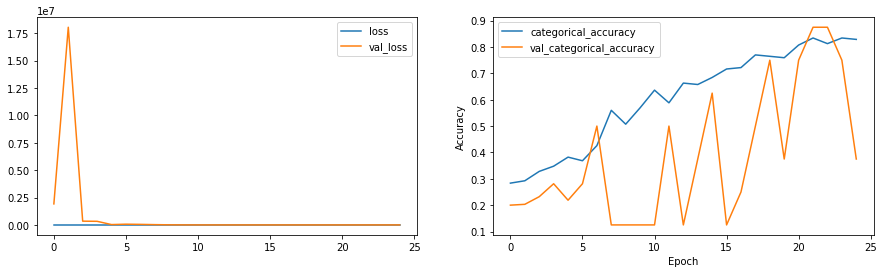

In [19]:
plot(history)